In [3]:
#update the pip verion of the boto3
!pip install --upgrade -q boto3==1.34.55
!pip install -q requests
!pip install -q requests_aws4auth

In [6]:
import pandas as pd
import xml.etree.ElementTree as ET
from html import unescape
import boto3
import botocore
import requests
from requests_aws4auth import AWS4Auth
from langchain.embeddings import BedrockEmbeddings

neptune_graph_client = boto3.client('neptune-graph')


In [7]:
LOCAL_CYPHER_FILE_LOCATION = "./data/health.stackexchange.com/opencypher"
DATA_S3_BUCKET = "shamika-hcls"
DATA_S3_PATH = "datasources/medical-qna-cyphers"

### Helper Functions 

In [8]:
def create_bedrock_client(service_name):
    """
    Create a Bedrock client using the provided service name and global AWS credentials.
    """
    return boto3.client(
        service_name=service_name
    )

def generate_embeddings(documents_list, modelId = "amazon.titan-embed-g1-text-02"):

    bedrock_runtime = create_bedrock_client("bedrock-runtime")
    bedrock_embeddings = BedrockEmbeddings(model_id=modelId, client=bedrock_runtime)
    
    embeddings_list = bedrock_embeddings.embed_documents(
        documents_list
    )

    return embeddings_list


def convert_to_neprune_embedding_format(embedding):

    return ";".join(str(val) for val in embedding)


def created_embeddings_in_neptune_format(documents):
    
    embeddings_list = generate_embeddings(documents)
    return [convert_to_neprune_embedding_format(embedding) for embedding in embeddings_list]


def execute_graph_query(query, neptune_endpoint):

    # Retrieve AWS credentials
    session = boto3.Session()
    credentials = session.get_credentials()
    current_credentials = credentials.get_frozen_credentials()
    
    aws_auth = AWS4Auth(current_credentials.access_key, current_credentials.secret_key, 'us-east-1', 'neptune-graph', session_token=current_credentials.token)

    headers = {
        "Content-Type": "application/json"
    }

    # Construct the payload with your query
    payload = {
        "query": query
        # Include other necessary parameters here
    }

    # Make the POST request to execute the query
    response = requests.post(neptune_endpoint,  auth=aws_auth, json=payload, headers=headers)

    # Check the response
    if response.status_code == 200:
        print("Query executed successfully:", response.json())
    else:
        print("Error executing query:", response.status_code, response.text)
        raise Exception("Error executing query")
    
    return response

### Data Preparation

In [11]:
s3_client = boto3.client('s3')

def save_cypher_csv_and_upload_s3(df, filename):
    full_file_name = f"{LOCAL_CYPHER_FILE_LOCATION}/{filename}.csv"
    df.to_csv(full_file_name, index=False)
    s3_client.upload_file(full_file_name, DATA_S3_BUCKET, f"{DATA_S3_PATH}/{filename}.csv")
    return full_file_name


#### Posts

In [12]:
tree = ET.parse('data/health.stackexchange.com/Posts.xml')
root = tree.getroot()

# Initialize a list to hold our extracted data
data = []

# Loop through each post in the XML
for post in root.findall('row'):
    data.append({
        ':ID': post.get('Id'),
        ':LABEL' : 'post',
        'postTypeId:Int': post.get('PostTypeId'),
        'acceptedAnswerId:Int' : post.get('AcceptedAnswerId'),
        'parentId:Int': post.get('ParentId'),
        'creationDate:DateTime': post.get('CreationDate'),
        'score:Int': post.get('Score'),
        'viewCount:Int': post.get('ViewCount'),
        # Unescape HTML entities in the Body
        'body:String': unescape(post.get('Body')),
        'ownerUserId:Int' : post.get('OwnerUserId'),
        #'ownerDisplayName:String': post.get('OwnerDisplayName'),
        #'LastEditorUserId:Int': post.get('LastEditorUserId'),
        'lastEditDate:DateTime': post.get('LastEditDate'),
        'lastActivityDate:DateTime': post.get('LastActivityDate'),
        'title:String': post.get('Title'),
        # Remove HTML tags for Tags
        'answerCount:Int': post.get('AnswerCount'),
        'tags:String': post.get('Tags').replace('<', '').replace('>', ',') if post.get('Tags') else None,
        'commentCount:Int': post.get('CommentCount'),
        'closedData:DateTime' : post.get('ClosedDate')
    })

# Convert the list of dictionaries into a DataFrame
df_posts = pd.DataFrame(data)


In [13]:
df_posts[~df_posts["acceptedAnswerId:Int"].isnull()].sort_values(by=["answerCount:Int"], ascending=False)

,:ID,:LABEL,postTypeId:Int,acceptedAnswerId:Int,parentId:Int,creationDate:DateTime,score:Int,viewCount:Int,body:String,ownerUserId:Int,lastEditDate:DateTime,lastActivityDate:DateTime,title:String,answerCount:Int,tags:String,commentCount:Int,closedData:DateTime
3661,7209,post,1,7210,None,2016-06-24T20:22:26.620,4,781,"<p>After watching the documentary <a href=""htt...",5027,2017-04-13T12:46:45.903,2018-04-23T13:47:20.200,What are trustworthy food and nutrition inform...,8,"nutrition,diet,",5,None
13835,29276,post,1,29280,None,2021-11-15T05:37:50.880,28,10678,<p>Things like gender and age and height and w...,21715,2021-11-15T22:15:56.800,2021-11-18T16:03:33.130,Why do doctors ask for your race?,7,"epidemiology,research,genetic-predisposition,r...",10,None
7883,15061,post,1,15065,None,2018-01-23T00:16:20.930,25,11223,<p>Influenza vaccines do not have satisfactory...,8973,2018-01-23T21:27:03.190,2018-01-27T14:47:02.737,Is it advisable for a healthy male in his earl...,6,"vaccination,influenza,mercury,",3,None
48,52,post,1,85,None,2015-03-31T22:33:47.010,112,6949,<p>My job requires long periods of computer sc...,59,2015-11-24T03:45:01.663,2019-11-23T18:36:52.357,How can I protect my eyesight when using compu...,6,"eye,computers,lifestyle,",1,None
10895,20970,post,1,20980,None,2020-02-03T19:32:51.930,35,14302,"<p>According to the data on the <a href=""https...",17521,2020-04-19T19:49:57.093,2020-04-19T19:49:57.093,Does COVID-19 have a case fatality rate of 41%...,5,"virus,infectious-diseases,death,covid-19,",11,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5034,10304,post,1,10309,None,2016-11-29T23:20:08.607,2,41,<p>I've been trying to reduce my intake of glu...,7503,2017-03-07T10:21:46.007,2017-03-07T10:21:46.007,Gluten in beer or not?,1,"diet,alcohol,nutrition,gluten,",0,None
5033,10302,post,1,10310,None,2016-11-29T22:05:45.793,2,75,"<p>Since Sunday, My right ear feels like somet...",7501,2016-11-29T22:14:40.580,2016-11-30T10:22:14.943,"I'm not sure, but might have something stuck i...",1,"ear,",1,2017-01-03T04:24:21.220
5028,10292,post,1,10293,None,2016-11-28T21:46:03.043,3,7417,<p>I'm trying to purchase glasses online but I...,7490,None,2016-11-28T22:11:22.760,Help reading an eyeglass prescription: What do...,1,"eye,prescription,glasses,astigmatism,",0,None
5008,10261,post,1,12465,None,2016-11-26T17:55:35.463,2,271,"<p>Recently, I had to overview some WiFi techn...",7459,2016-11-30T17:45:04.280,2017-05-31T00:10:15.177,is RADIO-SIGNAL Jammer safe for health?,1,"radioactivity,radiology,",2,None


In [39]:
pd.options.display.max_seq_items = 20000
pd.set_option(
    'display.max_colwidth', 2000
)

df_posts[df_posts[":ID"] == '10304']["body:String"]

5034    <p>I've been trying to reduce my intake of gluten and have found that my bowels are much more stable and regular. Does beer have gluten in it? I haven't found beer to be a problem for me. </p>\n
Name: body:String, dtype: object

##### Split the questions and answers 

* `postTypeId` is '1' means it is a question
* `postTypeId` is '2' means it is an answer

In [21]:
df_questions = df_posts[df_posts["postTypeId:Int"] == '1'] 
df_questions.drop(['postTypeId:Int', 'parentId:Int'], axis=1, inplace=True)
df_questions.shape

/tmp/ipykernel_5616/3379171962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_questions.drop(['postTypeId:Int', 'parentId:Int'], axis=1, inplace=True)


(7886, 15)

In [22]:
df_answers = df_posts[df_posts["postTypeId:Int"] == '2'] 
df_answers.drop(["acceptedAnswerId:Int", "viewCount:Int", "title:String", "answerCount:Int","tags:String", "closedData:DateTime"], axis=1, inplace=True)
df_answers.shape

/tmp/ipykernel_5616/1166006028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_answers.drop(["acceptedAnswerId:Int", "viewCount:Int", "title:String", "answerCount:Int","tags:String", "closedData:DateTime"], axis=1, inplace=True)


(6641, 11)

* Questions with accetped answers 


In [23]:
# Questions with accetped answers 
df_questions[~df_questions["acceptedAnswerId:Int"].isnull()].shape

(2531, 15)

* Count the values of each and create histogram


<Axes: xlabel='answerCount:Int'>

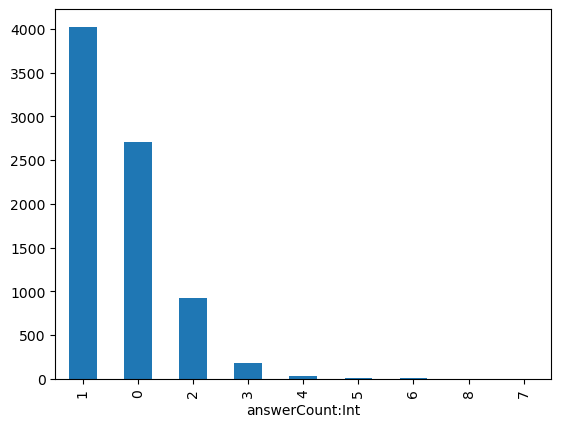

In [24]:
df_questions["answerCount:Int"].value_counts().plot(kind='bar')

##### Create questions and answers posts' embeddings using Amazon Bedrock Titan Model

* Let's combine the post title and the body to create the vector embeddings

In [26]:
documents = (df_questions["title:String"] + '\n' + df_questions["body:String"]).to_list()
df_questions["embedding:Vector"] = created_embeddings_in_neptune_format(documents)
df_questions


KeyboardInterrupt: 

* Now lets follow the same procedure for answers as well. 


In [ ]:
documents = df_answers[["body:String"]]

# count words in each value of dataframe add it to another column
documents["wordcount"] = documents["body:String"].apply(lambda x: len(x.split()))

/tmp/ipykernel_10404/1700615847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["wordcount"] = documents["body:String"].apply(lambda x: len(x.split()))


(array([326., 636., 755., 757., 624., 529., 490., 402., 338., 279., 212.,
        185., 142., 131., 107.,  94.,  92.,  55.,  60.,  54.,  56.,  38.,
         28.,  30.,  23.,  24.,  16.,  13.,  17.,  14.,  11.,   9.,   8.,
         11.,   7.,   2.,   8.,   6.,   5.,   6.,   4.,   1.,   1.,   4.,
          0.,   2.,   0.,   2.,   1.,   4.,   0.,   1.,   1.,   2.,   2.,
          3.,   1.,   2.,   0.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  10.  ,   44.42,   78.84,  113.26,  147.68,  182.1 ,  216.52,
         250.94,  285.36,  319.78,  354.2 ,  388.62,  423.04,  457.46,
         491.88,  526.3 ,  560.72,  595.14,  629.56,  663.98,  698.4 ,
         732.82,  767.24,  801.66,  836.08,  870.5 ,  904.92,  939.34,
         973.76, 1008.18, 1042.6 ,

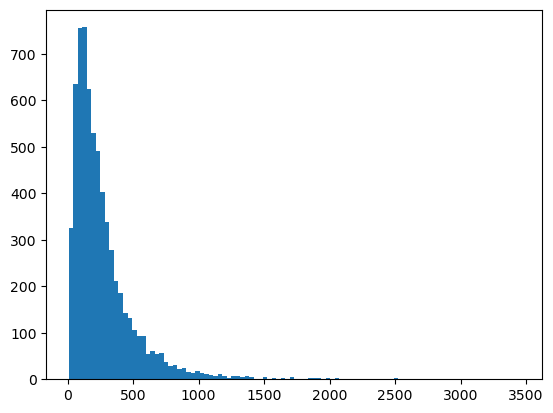

In [ ]:
import matplotlib.pyplot as plt
plt.hist(documents["wordcount"], bins=100)

##### Truncate the text greater than token length


In [16]:
import pandas as p
import numpy as np

documents.loc[documents["wordcount"] > 3000, 'body:String'] = documents[documents["wordcount"] > 3000]['body:String'].str.slice(0, 3000)


##### Create answer text embeddings

In [17]:
df_answers["embedding:Vector"] = created_embeddings_in_neptune_format(documents["body:String"].to_list())
df_answers

/tmp/ipykernel_10404/85003919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_answers["embedding:Vector"] = created_embeddings_in_neptune_format(documents["body:String"].to_list())


,:ID,:LABEL,postTypeId:Int,parentId:Int,creationDate:DateTime,score:Int,body:String,ownerUserId:Int,lastEditDate:DateTime,lastActivityDate:DateTime,commentCount:Int,embedding:Vector
5,7,post,2,6,2015-03-31T19:28:52.820,14,"<p>Generally speaking, it's best to leave blis...",22,None,2015-03-31T19:28:52.820,1,-0.26757812;0.084472656;0.3515625;-0.08935547;...
6,8,post,2,5,2015-03-31T19:29:37.167,14,"<p>Certainly not. By definition, it cannot br...",8,None,2015-03-31T19:29:37.167,1,0.8515625;-0.009033203;0.21484375;-0.25;-0.398...
7,9,post,2,5,2015-03-31T19:31:01.247,19,"<p>Actually, in the case of most drugs, it has...",22,None,2015-03-31T19:31:01.247,0,-0.16015625;-0.015991211;-0.12451172;0.0346679...
8,10,post,2,4,2015-03-31T19:36:37.267,25,<p>Both. Human cells largely exhibit a phenome...,22,2015-04-07T11:05:57.097,2015-04-07T11:05:57.097,11,0.27539062;-0.39453125;-0.060058594;-0.0198974...
10,12,post,2,3,2015-03-31T19:39:31.057,11,<p>Calcium carbonate is largely insoluble in a...,22,None,2015-03-31T19:39:31.057,0,0.3515625;0.2578125;0.12011719;0.020751953;-0....
...,...,...,...,...,...,...,...,...,...,...,...,...
14962,32674,post,2,1602,2023-11-26T12:05:02.687,2,<h1>Methods of monitoring blood pressure</h1>\...,14056,None,2023-11-26T12:05:02.687,0,-0.46244192;-0.42897865;0.5747445;-0.101017445...
14963,32675,post,2,5752,2023-11-26T12:20:55.067,2,<p>The British Journal of Sports Medicine publ...,14056,None,2023-11-26T12:20:55.067,0,-0.091796875;-0.114746094;0.21972656;0.15625;0...
14964,32676,post,2,11852,2023-11-26T13:30:08.563,-3,"<p>According to a Harvard medical study, 40% o...",27581,None,2023-11-26T13:30:08.563,1,-0.21484375;-0.51953125;0.111816406;-0.3222656...
14970,32684,post,2,31424,2023-11-29T23:34:39.167,2,<p>The respiratory and cardiac cycles vary in ...,17703,None,2023-11-29T23:34:39.167,0,0.07910156;-0.34960938;0.33984375;-0.15136719;...


##### Create Question and Answer relationship.

In [18]:
rel_answers_to_questions = df_answers[[":ID", "parentId:Int"]].rename(columns={":ID": ":END_ID", "parentId:Int": ":START_ID"})
rel_answers_to_questions[":TYPE"] = "answer"

##### Save posts cypher files as csv

In [19]:
save_cypher_csv_and_upload_s3(df_questions, "node_question_posts_cypher")
save_cypher_csv_and_upload_s3(df_answers, "node_answer_posts_cypher")
save_cypher_csv_and_upload_s3(rel_answers_to_questions, "rel_question_to_answer_posts_cypher")

'./data/health.stackexchange.com/opencypher/rel_question_to_answer_posts_cypher.csv'

#### Comments

In [4]:
tree = ET.parse('data/health.stackexchange.com/Comments.xml')
root = tree.getroot()

# Initialize a list to collect data
data = []
# Loop through each comment in the XML
for comment in root.findall('row'):
    data.append({
        ':ID': 'c_' + comment.get('Id'),
        'postId:Int': comment.get('PostId'),
        'score:Int': comment.get('Score'),
        'text:String': comment.get('Text'),
        'creationDate:Datetime': comment.get('CreationDate'),
        'userId:Int': comment.get('UserId'),
        ':LABEL' : 'comment'
    })

# Convert the list of dictionaries into a DataFrame
df_comments = pd.DataFrame(data)
df_comments.shape

(25931, 7)

##### Create comments text embeddings

In [10]:
df_comments["embedding:Vector"] = created_embeddings_in_neptune_format(df_comments["text:String"].to_list())
df_comments

,:ID,postId:Int,score:Int,text:String,creationDate:Datetime,userId:Int,:LABEL,embedding:Vector
0,c_1,8,1,Polonium-210 was more in line with what I was ...,2015-03-31T19:34:57.947,11,comment,0.6171875;-0.06982422;0.36523438;-0.37304688;-...
1,c_2,10,12,Some references in this answer would be nice.,2015-03-31T19:38:34.693,8,comment,-0.22167969;0.122558594;0.38867188;-0.73046875...
2,c_3,10,5,Hm. I don't have any of my textbooks immediate...,2015-03-31T19:41:25.630,22,comment,-0.022094727;0.30859375;-0.24609375;-0.3652343...
3,c_5,28,1,"Thanks, good to know. I was asking as when app...",2015-03-31T21:02:52.027,43,comment,-0.29296875;0.30273438;0.46875;-0.59765625;-0....
4,c_6,13,4,http://parenting.stackexchange.com/q/1443,2015-03-31T21:29:06.330,49,comment,-0.31835938;0.06347656;-0.07421875;-0.50390625...
...,...,...,...,...,...,...,...,...
25926,c_63903,32687,0,after some inspection I realised that when loo...,2023-12-01T18:05:32.757,27607,comment,-0.11376953;-0.27734375;-0.17480469;-0.0131835...
25927,c_63904,32687,1,Only if the level and size of the kidneys is i...,2023-12-01T20:32:38.160,27132,comment,-0.26757812;-0.06298828;-0.07519531;-0.8945312...
25928,c_63905,32687,0,@Maria I agree that this is difficult with onl...,2023-12-01T20:40:38.457,14056,comment,-0.00037002563;-0.45703125;0.14355469;-0.54296...
25929,c_63906,32687,0,Actually I’m going to make an edit. Disclaimer...,2023-12-01T20:46:21.090,14056,comment,-0.7109375;-0.265625;-0.22070312;-0.7109375;0....


##### Create comments to Post Relationship

In [11]:
rel_posts_comments = df_comments[[":ID", "postId:Int"]]
rel_posts_comments.rename(columns={"postId:Int": ":START_ID", ":ID": ":END_ID"}, inplace=True)
rel_posts_comments[":TYPE"] = "has_comment"

/tmp/ipykernel_16202/3247812114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_posts_comments.rename(columns={"postId:Int": ":START_ID", ":ID": ":END_ID"}, inplace=True)
/tmp/ipykernel_16202/3247812114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_posts_comments[":TYPE"] = "has_comment"


##### Save Comments and Relationships

In [12]:
save_cypher_csv_and_upload_s3(df_comments, "node_comments_cypher")
save_cypher_csv_and_upload_s3(rel_posts_comments, "rel_post_comments_cypher")         

'./data/health.stackexchange.com/opencypher/rel_post_comments_cypher.csv'

#### Post History

In [22]:
# tree = ET.parse('data/health.stackexchange.com//PostHistory.xml')
# root = tree.getroot()

# # Initialize a list to collect data
# data = []

# # Extract data from each post history entry
# for entry in root.findall('row'):
#     data.append({
#         ':ID': entry.get('Id'),
#         'postHistoryTypeId:Int': entry.get('PostHistoryTypeId'),
#         'postId:Int': entry.get('PostId'),
#         #'RevisionGUID': entry.get('RevisionGUID'),
#         'creationDate:DateTime': entry.get('CreationDate'),
#         'userId:String': entry.get('UserId'),
#         'text:String': entry.get('Text'),  # Decodes HTML entities in the text
#         ':LABEL' : 'answer'
#     })

# # Convert to DataFrame
# df_post_history = pd.DataFrame(data)

# # Display the DataFrame to verify contents
# df_post_history.head()

##### Create PostHistory to Posts Relationships

In [23]:
# rel_post_history = df_post_history[[":ID", "postId:Int"]]
# rel_post_history.rename(columns={"postId:Int": ":START_ID", ":ID": ":END_ID"}, inplace=True)
# rel_post_history[":TYPE"] = "has_answer"

##### Save to History and Relashionships

In [24]:
# save_cypher_csv_and_upload_s3(df_post_history, "node_history_cypher")
# save_cypher_csv_and_upload_s3(rel_post_history, "rel_post_history_cypher")   

#### Post Links

In [11]:

tree = ET.parse('data/health.stackexchange.com/PostLinks.xml')
root = tree.getroot()

# Initialize a list to collect data
data = []

# Extract data from each post link entry
for entry in root.findall('row'):
    data.append({
        ':START_ID': entry.get('PostId'),
        ':END_ID': entry.get('RelatedPostId'),
        'creationDate:DateTime': entry.get('CreationDate'),
        'linkTypeId:Int': entry.get('LinkTypeId'),
        ":TYPE" : "relates_to"
    })

# Convert to DataFrame
rel_post_links = pd.DataFrame(data)

rel_post_links.head()

,:START_ID,:END_ID,creationDate:DateTime,linkTypeId:Int,:TYPE
0,52,79,2015-04-01T03:30:24.763,1,relates_to
1,102,103,2015-04-01T14:24:54.137,1,relates_to
2,6,75,2015-04-01T15:44:53.810,1,relates_to
3,75,6,2015-04-01T15:51:58.103,1,relates_to
4,237,241,2015-04-02T23:17:13.317,1,relates_to


##### Save post links relationships

In [12]:
save_cypher_csv_and_upload_s3(rel_post_links, "rel_post_links")

'./data/health.stackexchange.com/opencypher/rel_post_links.csv'

In [13]:
# tree = ET.parse('data/health.stackexchange.com/Tags.xml')
# root = tree.getroot()

# # Initialize a list to collect data
# data = []

# # Extract data from each tag entry
# for entry in root.findall('row'):
#     data.append({
#         'Id': entry.get('Id'),
#         'TagName': entry.get('TagName'),
#         'Count': entry.get('Count'),
#         'ExcerptPostId': entry.get('ExcerptPostId'),
#         'WikiPostId': entry.get('WikiPostId')
#     })

# # Convert to DataFrame
# df_tags = pd.DataFrame(data)
# df_tags

#### Users

In [14]:
# Replace 'path_to_your_file/Tags.xml' with the actual path to your XML file
tree = ET.parse('data/health.stackexchange.com/Users.xml')
root = tree.getroot()

# Initialize a list to collect data
data = []

# Extract data from each tag entry
for entry in root.findall('row'):
    data.append({
        ':ID': 'u_' + entry.get('Id'),
        'location:String' : entry.get('Location'),
        'reputation:Int': entry.get('Reputation'),
        'aboutMe:String': unescape(entry.get('AboutMe')) if entry.get('AboutMe') is not None else None,
        ':LABEL' : 'user'
    })

# Convert to DataFrame
df_users = pd.DataFrame(data)

df_users

,:ID,location:String,reputation:Int,aboutMe:String,:LABEL
0,u_-1,on the server farm,1,"<p>Hi, I'm not really a person.</p>\r\n<p>I'm ...",user
1,u_1,"New York, NY",101,\n<p>Developer at Stack Overflow focusing on p...,user
2,u_2,None,141,"<p><a href=""//stackoverflow.com"">Stack Overflo...",user
3,u_3,Downtown Burbank,101,<p>Topics you might be interested in reading a...,user
4,u_4,"Trento, Province of Trento, Italy",98,"<p>Chief Technical Officer at <a href=""https:/...",user
...,...,...,...,...,...
20858,u_27608,None,1,None,user
20859,u_27609,None,101,"<p>MD,\nPhD in pharmacoepidemiology</p>\n<p>Mo...",user
20860,u_27610,Spain,1,<p>Mundo-excel is a website where you will fin...,user
20861,u_27611,Russia,101,<p>Interested in a position as an IT professio...,user


In [13]:
# user_embeddings = generate_embeddings(df_users["aboutMe:String"].to_list())
# df_users["embedding:Vector"] = user_embeddings
# df_users

In [15]:
save_cypher_csv_and_upload_s3(df_users, "node_users_cyper")

'./data/health.stackexchange.com/opencypher/node_users_cyper.csv'

##### Add posts to user relationship

In [16]:
rel_questions_users = df_questions[[':ID','ownerUserId:Int']].rename(columns={'ownerUserId:Int' : ':END_ID', ':ID' : ':START_ID'})
rel_questions_users[":END_ID"] = "u_" + rel_questions_users[":END_ID"]
rel_questions_users[":TYPE"] = "owns"
rel_questions_users


,:START_ID,:END_ID,:TYPE
0,2,u_8,owns
1,3,NaN,owns
2,4,u_11,owns
3,5,u_11,owns
4,6,u_16,owns
...,...,...,...
14966,32678,u_27578,owns
14967,32679,u_16786,owns
14968,32682,u_27593,owns
14969,32683,u_27601,owns


In [17]:
rel_answers_to_users = df_questions[[':ID','ownerUserId:Int']].rename(columns={'ownerUserId:Int' : ':END_ID', ':ID' : ':START_ID'})
rel_answers_to_users[":END_ID"] = "u_" + rel_answers_to_users[":END_ID"]
rel_answers_to_users[":TYPE"] = "owns"
rel_answers_to_users

,:START_ID,:END_ID,:TYPE
0,2,u_8,owns
1,3,NaN,owns
2,4,u_11,owns
3,5,u_11,owns
4,6,u_16,owns
...,...,...,...
14966,32678,u_27578,owns
14967,32679,u_16786,owns
14968,32682,u_27593,owns
14969,32683,u_27601,owns


In [18]:
save_cypher_csv_and_upload_s3(rel_questions_users, "rel_questions_users_cypher")
save_cypher_csv_and_upload_s3(rel_answers_to_users, "rel_answers_users_cypher")

'./data/health.stackexchange.com/opencypher/rel_answers_users_cypher.csv'

In [23]:
# tree = ET.parse('data/health.stackexchange.com//Votes.xml')
# root = tree.getroot()

# # Initialize a list to collect vote data
# votes_data = []

# # Extract data from each vote entry
# for entry in root.findall('row'):
#     votes_data.append({
#         'Id': entry.get('Id'),
#         'PostId': entry.get('PostId'),
#         'VoteTypeId': entry.get('VoteTypeId'),
#         'CreationDate': entry.get('CreationDate')
#     })

# # Convert to DataFrame
# df_votes = pd.DataFrame(votes_data)

# # Convert data types
# df_votes['CreationDate'] = pd.to_datetime(df_votes['CreationDate'])
# df_votes[['Id', 'PostId', 'VoteTypeId']] = df_votes[['Id', 'PostId', 'VoteTypeId']].apply(pd.to_numeric, errors='coerce')

# # Display the DataFrame to verify contents
# df_votes.head()

### Create Neptune Analytics Graph

In [16]:

graph_name = 'sha-health-qna-kg-v5'

graph_creation_response = neptune_graph_client.create_graph(
    graphName=graph_name,
    publicConnectivity=True,
    vectorSearchConfiguration={
        'dimension': 1536
    },
    replicaCount=0,
    deletionProtection=False,
    provisionedMemory=128  
)

if graph_creation_response["ResponseMetadata"]["HTTPStatusCode"] == 201 :
    print("Graph creation process started successfully")



ConflictException: An error occurred (ConflictException) when calling the CreateGraph operation: Graph with name sha-health-qna-kg-v5 already exists!

In [27]:
from time import sleep

graph_response = neptune_graph_client.get_graph(
    graphIdentifier=graph_creation_response['id']
)

while graph_response['status'] == 'CREATING':
    sleep(15)
    print('Graph is still creating...')
    
    graph_response = neptune_graph_client.get_graph(
        graphIdentifier=graph_creation_response['id']
    )

print(f"Graph with id {graph_response['id']} with endpoint {graph_response['endpoint']} is {graph_response['status']}. ")


Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph is still creating...
Graph with id g-we143s0qj2 with endpoint g-we143s0qj2.us-east-1.neptune-graph.amazonaws.com is AVAILABLE. 


### Insert all the cypher data into Neptune Graph

In [25]:
#neptune_endpoint = f"https://{graph_response['endpoint']}/openCypher"
neptune_endpoint = f"https://g-we143s0qj2.us-east-1.neptune-graph.amazonaws.com/openCypher"

In [8]:

query = '''CALL neptune.load({ source : 's3://shamika-hcls/datasources/medical-qna-cyphers/', region : 'us-east-1', format: 'opencypher', failOnError: True})'''  

execute_graph_query(query, neptune_endpoint)


Error executing query: 400 {"reason":"MALFORMED_QUERY","message":"Required END_ID field is missing"}


Exception: Error executing query

* Alternatively you can create and import data to the neptune graph in a single operation like below.

In [13]:
# response = neptune_analytics_client.create_graph_using_import_task(
#     graphName='sha-health-qna-kg-v3',
#     publicConnectivity=False,
#     vectorSearchConfiguration={
#         'dimension': 1536
#     },
#     replicaCount=0,
#     deletionProtection=False,
#     # importOptions={
#     #     'neptune': {
#     #         's3ExportPath': "s3://shamika-hcls/datasources/medical-qna/"
#     #     }
#     # },
#     failOnError=True,
#     source='s3://shamika-hcls/datasources/medical-qna-cyphers/',
#     format='CSV',
#     roleArn='arn:aws:iam::111918798052:role/sha-neptune-analytics-role'
# )

#### Verify the data ingetion by selecting a post node with its neighboring nodes

In [27]:
sample_post_id = 4

query = '''
MATCH (p:post)
RETURN p
ORDER BY rand()
LIMIT 1
'''
execute_graph_query(query, neptune_endpoint)



Query executed successfully: {'results': [{'p': {'~id': '24458', '~entityType': 'node', '~labels': ['post'], '~properties': {'ownerUserId': 20242, 'creationDate': '2020-08-17T02:33:35Z', 'body': '<p>There has been surprisingly little research on the topic, and as might be expected given the lack if new data, recent studies have not supported a general libido lowering effect of vasectomy.  A study in Brazil from 2005 looked at 64 patients undergoing vasectomy and found a small but statistically significant (at p < 0.001) improvement in international index of erectile function scores driven by increases in desire and sexual satisfaction.  However, it should be noted that while 67% had improved scores, 17% had worse scores, 16% reported no change (Botero et al,  Braz J Urol. Sep-Oct 2005;31(5):452-8)</p>\n<p>Orr and Moore found from a group of 1000 consecutive vasectomies that only 1% reported "psycho-sexual problems such as decreased libido, ejaculatory problems, depression" (r Med J. 19

<Response [200]>

In [28]:
sample_post_id = 4

query = '''
MATCH (p:post)
WHERE p.score = 26 and p.answerCount = 4
OPTIONAL MATCH (p)-[:answer]->(a:post)
RETURN p as question, a as answer
'''
response = execute_graph_query(query, neptune_endpoint)
response.json()

Query executed successfully: {'results': [{'question': {'~id': '6', '~entityType': 'node', '~labels': ['post'], '~properties': {'ownerUserId': 16, 'creationDate': '2015-03-31T19:26:15Z', 'body': '<p>While playing indoor soccer a couple days ago, I was fouled and fell forwards so that my hand skidded across the court a bit. It left the blister as you see in the image here:</p>\n\n<p><img src="https://i.stack.imgur.com/PDHo5m.jpg" alt="the blister"></p>\n\n<p>What should I consider when deciding to remove this blister? I could open and drain this blister, removing the excess skin afterwards, or leave it as is.</p>\n\n<p>I figure since it\'s in a place that is likely to be touched/disrupted I should remove it since it\'s likely to open anyways.</p>\n', 'lastActivityDate': '2015-04-15T18:13:37Z', 'acceptedAnswerId': 478, 'tags': 'wound,removal,', 'score': 26, 'lastEditDate': '2015-04-13T04:27:47Z', 'viewCount': 6585, 'answerCount': 4, 'title': 'What should I consider when deciding to remov

{'results': [{'question': {'~id': '6',
    '~entityType': 'node',
    '~labels': ['post'],
    '~properties': {'ownerUserId': 16,
     'creationDate': '2015-03-31T19:26:15Z',
     'body': '<p>While playing indoor soccer a couple days ago, I was fouled and fell forwards so that my hand skidded across the court a bit. It left the blister as you see in the image here:</p>\n\n<p><img src="https://i.stack.imgur.com/PDHo5m.jpg" alt="the blister"></p>\n\n<p>What should I consider when deciding to remove this blister? I could open and drain this blister, removing the excess skin afterwards, or leave it as is.</p>\n\n<p>I figure since it\'s in a place that is likely to be touched/disrupted I should remove it since it\'s likely to open anyways.</p>\n',
     'lastActivityDate': '2015-04-15T18:13:37Z',
     'acceptedAnswerId': 478,
     'tags': 'wound,removal,',
     'score': 26,
     'lastEditDate': '2015-04-13T04:27:47Z',
     'viewCount': 6585,
     'answerCount': 4,
     'title': 'What should 

In [21]:
query2 = '''
MATCH( n {`~id`: "6"} )
CALL neptune.algo.vectors.get(n)
YIELD embedding
RETURN n, embedding
'''

response = execute_graph_query(query, neptune_endpoint)
response.json()['results'][0]['embedding']

NameError: name 'execute_graph_query' is not defined

{'question': {'~id': '6', '~entityType': 'node', '~labels': ['post'], '~properties': {'ownerUserId': 16, 'creationDate': '2015-03-31T19:26:15Z', 'body': '<p>While playing indoor soccer a couple days ago, I was fouled and fell forwards so that my hand skidded across the court a bit. It left the blister as you see in the image here:</p>\n\n<p><img src="https://i.stack.imgur.com/PDHo5m.jpg" alt="the blister"></p>\n\n<p>What should I consider when deciding to remove this blister? I could open and drain this blister, removing the excess skin afterwards, or leave it as is.</p>\n\n<p>I figure since it\'s in a place that is likely to be touched/disrupted I should remove it since it\'s likely to open anyways.</p>\n', 'lastActivityDate': '2015-04-15T18:13:37Z', 'acceptedAnswerId': 478, 'tags': 'wound,removal,', 'score': 26, 'lastEditDate': '2015-04-13T04:27:47Z', 'viewCount': 6585, 'answerCount': 4, 'title': 'What should I consider when deciding to remove a blister or not?', 'commentCount': 0}},

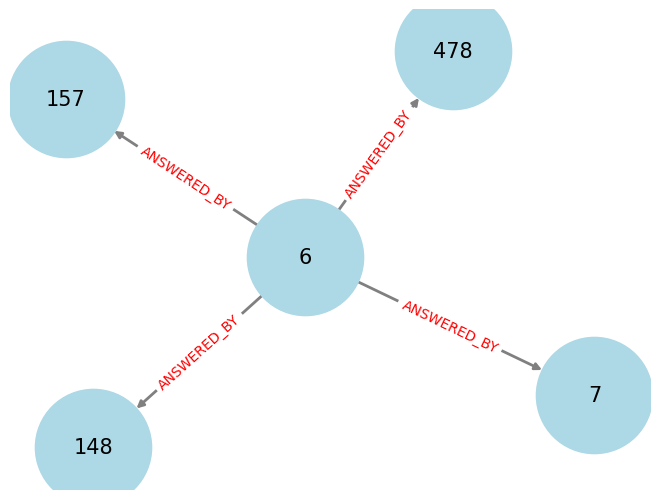

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
import requests  # Assuming you're using requests to make the HTTP request

# Example response from requests.post() method
# response = requests.post(neptune_endpoint,  auth=aws_auth, json=payload, headers=headers)

# Convert the response content to a Python dictionary
data = response.json()

# Assuming 'data' contains the 'results' key with the necessary information
results = data['results']  # Adjust based on the actual structure of your response

G = nx.DiGraph()

for item in results:
    print(item)
    question = item['question']
    answer = item.get('answer', {})  # Using .get() to avoid KeyError if 'answer' is missing
    
    # Add question node
    q_id = question['~id']
    G.add_node(q_id, label='Question', title=question['~properties']['title'][:30])  # Truncate title for simplicity
    
    # Add answer node and edge from question to answer
    if answer:
        a_id = answer['~id']
        G.add_node(a_id, label='Answer', score=answer['~properties']['score'])
        G.add_edge(q_id, a_id, relationship='ANSWERED_BY')
        
        # If users are included, you could add them as nodes as well
        # And add edges representing "POSTED_BY" relationships

# Basic visualization
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=7000, node_color="lightblue", font_size=15, width=2, edge_color="gray")
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['relationship'] for u, v, d in G.edges(data=True)}, font_color='red')
plt.show()


### Get closest matches by embeddings

In [1]:
user_question = "Does beer have gluten in it?"
q_embedding = generate_embeddings([user_question])
q_embedding


NameError: name 'generate_embeddings' is not defined

In [46]:
retrieval_response = f'''
CALL neptune.algo.vectors.topKByEmbedding(
  {str(q_embedding[0])},
  {{
    topK: 2,
    concurrency: 1
  }}
)
YIELD embedding, node, score
RETURN embedding, node, score
'''

response = execute_graph_query(retrieval_response, neptune_endpoint)
response

Query executed successfully: {'results': [{'embedding': [-0.5078125, -0.06884765625, 0.07763671875, -0.99609375, -0.60546875, -0.255859375, 0.294921875, -0.000568389892578125, -0.007537841796875, 0.173828125, -0.65625, 0.578125, -0.18359375, -0.12890625, 0.0245361328125, -0.59765625, -0.053955078125, -0.28125, -0.1611328125, 0.0028228759765625, 0.33203125, 0.220703125, 0.4921875, 0.158203125, -0.099609375, -0.373046875, 0.2431640625, 0.59375, 0.5859375, -0.0625, 0.5546875, -0.11328125, -0.53515625, -0.060546875, 1.015625, -0.59765625, -0.056396484375, -0.61328125, 0.953125, -0.359375, 0.16015625, 1.2265625, 0.75, 0.7421875, 0.5703125, 0.19921875, -0.0498046875, -0.224609375, -0.046142578125, 0.474609375, 0.337890625, 0.00164031982421875, -0.1328125, 0.439453125, -0.41015625, -0.6953125, 0.2275390625, 0.255859375, 0.1708984375, -0.3046875, -0.16796875, -0.30859375, 0.10595703125, -0.1552734375, 0.392578125, -0.18359375, 1.2734375, -0.77734375, 0.166015625, -0.0361328125, 0.4453125, 0.25

<Response [200]>

In [29]:
neptune_endpoint

'https://g-we143s0qj2.us-east-1.neptune-graph.amazonaws.com/openCypher'

In [43]:
response = neptune_graph_client.execute_query(
    graphIdentifier="g-we143s0qj2",
    queryString=f"""
            CALL neptune.algo.vectors.topKByEmbedding(
            {str(q_embedding[0])},
              {{
                topK: 2,
                concurrency: 1
              }}
            )
            YIELD embedding, node, score
            RETURN embedding, node, score
            """,
    language='OPEN_CYPHER',
    
)

In [44]:
response

{'ResponseMetadata': {'RequestId': 'f05a359f-6d08-47cb-85ae-7236b7aac6cd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'transfer-encoding': 'chunked',
   'content-type': 'application/json;charset=UTF-8',
   'x-amzn-requestid': 'f05a359f-6d08-47cb-85ae-7236b7aac6cd'},
  'RetryAttempts': 0},
 'payload': <botocore.response.StreamingBody at 0x7f53843a1a20>}